# Plot regret of NCC-UCRL2 (new name of Algorithm1) for different window sizes


In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

from src import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


In [6]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [13]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [14]:
new_contexts.shape, new_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


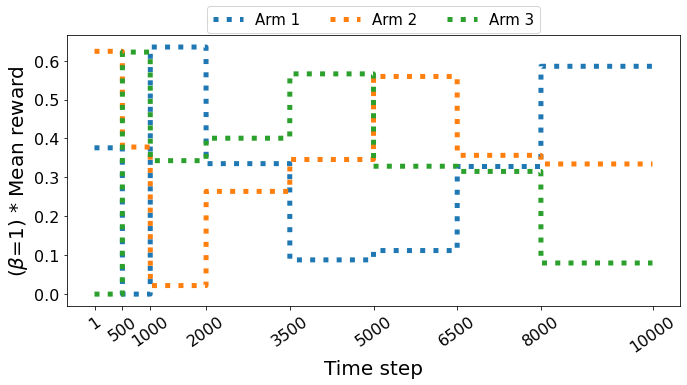

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


### Non-stationarity in costs

In [16]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [17]:
cost_means_range = [0.01, 0.07]

In [18]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [19]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [20]:
interval_means

[array([0.03247241, 0.06704286, 0.05391964, 0.04591951, 0.01936112]),
 array([0.01935967, 0.01348502, 0.06197057, 0.0460669 , 0.05248435]),
 array([0.01123507, 0.06819459, 0.05994656, 0.02274035, 0.0209095 ]),
 array([0.02100427, 0.02825453, 0.04148539, 0.0359167 , 0.02747375]),
 array([0.04671117, 0.01836963, 0.02752868, 0.03198171, 0.0373642 ])]

In [21]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [22]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

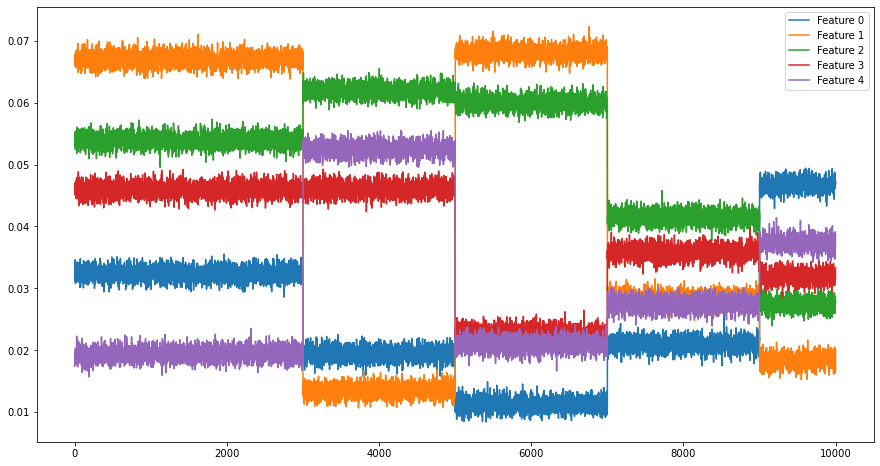

In [23]:
plot_costs(get_costs(), new_contexts.shape[0])

In [24]:
costs_obj = get_costs()

In [25]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [26]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [27]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [28]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

## Plot expected reward minus sum of costs

In [29]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.22633150496472904
Min expected gain for arm 2: -0.2036502630607873
Min expected gain for arm 3: -0.22429558772004018


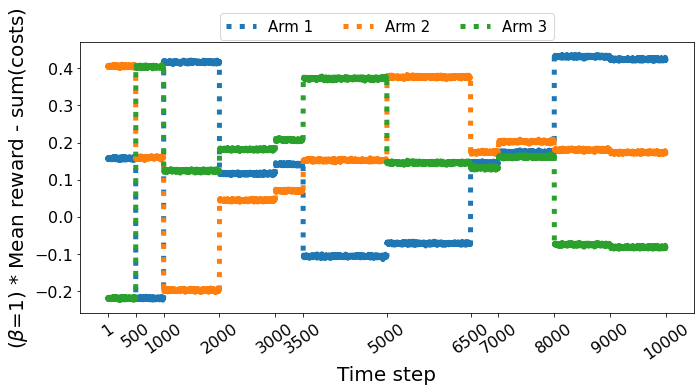

In [30]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [31]:
all_change_points = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

## Testing on non-stationary data

In [32]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [33]:
w_lengths = [300, 500, 700, 1500]
gains_for_w = {}

for w_length in w_lengths:
    np.random.seed(42)
    print(f'\tEvaluation for w = {w_length}')
    gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    rewards_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    costs_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

    for i in range(NUM_REPETITIONS):
        s = time.time()
        p_alg1 = algorithms.Algorithm1(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_num_observations=new_contexts.shape[1],
            beta=BETA,
            delta=0.04,
            window_length=w_length,
            costs_range=COSTS_RANGE_SIZE,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_alg1, reward_alg1, cost_alg1, _ = evaluation.evaluate_on_synthetic_data(
                p_alg1,
                new_contexts[:NUM_OF_TRIALS],
                new_rewards[:NUM_OF_TRIALS],
                costs_vector[:NUM_OF_TRIALS],
                beta=BETA,
                stop_after=NUM_OF_TRIALS,
                return_full=True,
            )
            print(f"Took {time.time() - s} seconds")
            gains_alg1[i, :] = gain_alg1
            rewards_alg1[i, :] = reward_alg1
            costs_alg1[i, :] = cost_alg1

    gain_alg1 = np.mean(gains_alg1, axis=0)
    reward_alg1 = np.mean(rewards_alg1, axis=0)
    cost_alg1 = np.mean(costs_alg1, axis=0)
    print(f"Average gain: {gain_alg1[-1]}")
    gains_for_w[w_length] = gain_alg1

	Evaluation for w = 300
Took 0.0010731220245361328 seconds
Round 0, time 2022-11-01 18:30:52.459420
Round 1000, time 2022-11-01 18:33:42.596097
Round 2000, time 2022-11-01 18:36:39.749525
Round 3000, time 2022-11-01 18:39:32.256628
Round 4000, time 2022-11-01 18:42:10.702969
Round 5000, time 2022-11-01 18:45:12.860218
Round 6000, time 2022-11-01 18:48:12.787696
Round 7000, time 2022-11-01 18:51:16.608420
Round 8000, time 2022-11-01 18:54:17.337259
Round 9000, time 2022-11-01 18:57:22.091400
Algorithm1 (beta=1, delta=0.04, w=300)
Beta = 1
Total gain: 6463.167277694499
	Total reward: 7524.0
	Total cost: 1060.8327223055164
Execution time: 29.2m
Took 1751.93950009346 seconds
Took 0.009366035461425781 seconds
Round 0, time 2022-11-01 19:00:04.416052
Round 1000, time 2022-11-01 19:02:15.911872
Round 2000, time 2022-11-01 19:04:32.507562
Round 3000, time 2022-11-01 19:06:48.583298
Round 4000, time 2022-11-01 19:09:05.300447
Round 5000, time 2022-11-01 19:11:32.289798
Round 6000, time 2022-11-

Round 4000, time 2022-11-02 00:19:30.966442
Round 5000, time 2022-11-02 00:22:18.175918
Round 6000, time 2022-11-02 00:25:05.696729
Round 7000, time 2022-11-02 00:27:52.711360
Round 8000, time 2022-11-02 00:30:39.877084
Round 9000, time 2022-11-02 00:33:26.981145
Algorithm1 (beta=1, delta=0.04, w=700)
Beta = 1
Total gain: 2543.49358400258
	Total reward: 4419.0
	Total cost: 1875.5064159974268
Execution time: 27.6m
Took 1654.5652928352356 seconds
Took 0.004714012145996094 seconds
Round 0, time 2022-11-02 00:36:14.325492
Round 1000, time 2022-11-02 00:38:42.655429
Round 2000, time 2022-11-02 00:41:28.450896
Round 3000, time 2022-11-02 00:44:14.155454
Round 4000, time 2022-11-02 00:46:59.813121
Round 5000, time 2022-11-02 00:49:45.177376
Round 6000, time 2022-11-02 00:52:31.348334
Round 7000, time 2022-11-02 00:55:16.805434
Round 8000, time 2022-11-02 00:58:03.471368
Round 9000, time 2022-11-02 01:00:49.465852
Algorithm1 (beta=1, delta=0.04, w=700)
Beta = 1
Total gain: 4341.349262225094
	T

### Oracle

In [34]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_points, all_change_points[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [35]:
gains_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_num_observations=new_contexts.shape[1],
        beta=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_oracle, reward_oracle, cost_oracle, _ = evaluation.evaluate_on_synthetic_data(
            p_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_oracle[i, :] = gain_oracle
        rewards_oracle[i, :] = reward_oracle
        costs_oracle[i, :] = cost_oracle


gain_oracle = np.mean(gains_oracle, axis=0)
reward_oracle = np.mean(rewards_oracle, axis=0)
cost_oracle = np.mean(costs_oracle, axis=0)
print(f"Average gain: {gain_oracle[-1]}")

Took 0.6276779174804688 seconds
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8719.532153825721
	Total reward: 9032.0
	Total cost: 312.46784617428966
Execution time: 0.1s
Took 0.10484814643859863 seconds
Took 0.6353099346160889 seconds
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8719.532153825721
	Total reward: 9032.0
	Total cost: 312.46784617428966
Execution time: 0.1s
Took 0.1091163158416748 seconds
Took 0.6256911754608154 seconds
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8719.532153825721
	Total reward: 9032.0
	Total cost: 312.46784617428966
Execution time: 0.1s
Took 0.10398483276367188 seconds
Took 0.6243200302124023 seconds
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8719.532153825721
	Total reward: 9032.0
	Total cost: 312.46784617428966
Execution time: 0.1s
Took 0.10606718063354492 seconds
Took 0.6238691806793213 seconds
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8719.532153825721
	Total reward: 9032.0
	Total cost: 312.46784617428966
Execution time: 0.1s
Took

## Save the data

In [36]:
regrets = {k: gain_oracle-v for k,v in gains_for_w.items()}

In [37]:
regrets

{300: array([3.82589917e-01, 9.82589917e-01, 2.00980804e+00, ...,
        2.95867210e+03, 2.95875002e+03, 2.95922960e+03]),
 500: array([3.82589917e-01, 1.18258992e+00, 1.80980804e+00, ...,
        4.28059245e+03, 4.28109117e+03, 4.28179263e+03]),
 700: array([5.82589917e-01, 9.82589917e-01, 1.80980804e+00, ...,
        5.12272416e+03, 5.12301445e+03, 5.12350769e+03]),
 1500: array([9.82589917e-01, 1.98258992e+00, 3.00980804e+00, ...,
        6.55010600e+03, 6.55041046e+03, 6.55071891e+03])}

In [38]:
with open('experiments/nursery/results/regrets_for_w.pickle', 'wb') as f:
    pickle.dump(regrets , f)

In [39]:
with open('experiments/nursery/results/regrets_for_w.pickle', 'rb') as f:
    regrets = pickle.load(f)

In [40]:
all_change_point_values

[1, 500, 1000, 2000, 3000, 3500, 5000, 6500, 7000, 8000, 9000, 10000]

In [41]:
def plot_regrets(regret_dict, reward_change_points=(), cost_change_points=(), all_change_point_values=(),):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'blue'),
        1: ('>', 'g'),
        2: ('d','m'),
        3: ('<','goldenrod'),
        4: ('s','r'),
        5: ('o','dodgerblue'),
        6: ('^', 'k'),
    }
    
    sorted_regret_dict = {
        k:v for k,v in sorted(regret_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline=0
    for regret in sorted_regret_dict.values():
        max_vline=max(max_vline, max(regret))
        
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4
    )
        
    for ind, (label, regret) in enumerate(sorted_regret_dict.items()):
        
        
        label_new = f"w={label}"
        
        mark, color = ind_to_params[ind % 7]
        line, = ax.plot(regret, label=label_new, linestyle=':', 
                marker=mark, markevery=750, markersize=11, markeredgewidth=1.5,
                fillstyle='none', color=color,
                linewidth=3,
               )
        
        
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=25)
    plt.yticks(fontsize=25)
    
    ax.set_xlabel("Time step", fontsize=38)
    ax.set_ylabel('Regret', fontsize=38)
    
    plt.legend(prop={'size': 22.5}, ncol=1);
    
    plt.savefig('nursery_window_regret.pdf', bbox_inches='tight')
    
    plt.show();

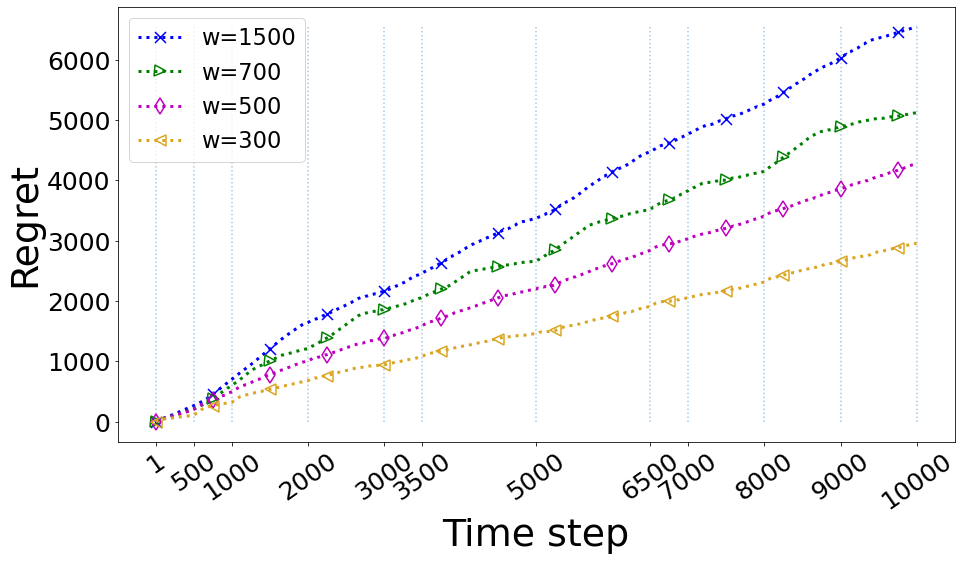

In [42]:
plot_regrets(
    regrets,
    reward_change_points=all_change_points,
    cost_change_points=cost_change_points,
    all_change_point_values=all_change_points,
)
